In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Supplier Commitment Under a Forecast-Commitment Contract

#### The problem
- Subject: The customer /
           The supplier
           
**`Stage 1`**
the customer provides the supplier its order forecast, $\bar{f}$.
the supplier then makes a commitment to the customer $C$

**`Stage 2`**
according to the terms of the contract, the customer must order at least $\alpha \bar{f}$, $ 0 ≤ \alpha ≤ 1$, unless the supplier has committed to a smaller amount. the customer is not forced to order more than the supplier is willing to commit and is not required to order more than C even if his original forecast exceeded C.

In exchange for the fractional-purchase clause of the contract, the supplier agrees to pay a linear penalty for any shortfall of its commitment from the forecast.


The purchase order sent is more than the Sale Order ( actual ordering ), and Sale Orders is more than Delivery Order.

In [2]:
#import data
inv = pd.read_csv("Inventory.csv")
fc_cols = [col for col in inv.columns if col.startswith('F')]

In [3]:
# take difference each forecast with actual delivery
diff_cols = ["diff_" + sub for sub in fc_cols]
inv[diff_cols] = inv[fc_cols].sub(inv['Act_del'], axis=0).abs()
inv['count_period'] = inv[fc_cols].notnull().count(axis=1) # number of period of the forecast

# difference percentage of difference
diff_perc_cols = ["perc_" + sub for sub in diff_cols]
inv[diff_perc_cols] = inv[diff_cols].div(inv['Act_del'], axis=0).replace(np.inf, 1)

In [4]:
# Mean Squared Error (MSE)
inv['mse'] = inv[diff_cols].apply(lambda x: x.mean()**2, axis=1)

# Root Mean Squared Error (RMSE)
inv['rmse'] = np.sqrt(inv['mse'])

# Mean Absolute Error (MAE)
inv['mae'] = inv[diff_cols].apply(lambda x: x.mean(), axis=1)

# Mean Absolute Percentage Error (MAPE)
inv['mape'] = inv['mae'].div(inv['Act_del']).replace(np.inf, 1)

# Mean Percentage Error (MPE)


# Coefficient Variation (CV)
inv['cv'] = inv['rmse'].mul(inv['count_period']).div(np.sum(inv[fc_cols], axis=1))

In [6]:
idx = ['Period','Material','Customer_name']
keep = diff_perc_cols+idx
perc_diff_inv = inv[keep]

perc_df = pd.wide_to_long(perc_diff_inv, "perc_diff_F", i=idx, j="period_inadv")
perc_df.reset_index(inplace=True)

In [7]:
error = inv[idx+['mape','cv']]
error

,Period,Material,Customer_name,mape,cv
0,DEC,GP22 NAT,BROTHER,0.113636,0.128205
1,JAN,GP22 NAT,BROTHER,0.217455,0.192142
2,FEB,GP22 NAT,BROTHER,0.447154,0.343321
3,MAR,GP22 NAT,BROTHER,0.098413,0.093093
4,APR,GP22 NAT,BROTHER,0.255102,0.203252
...,...,...,...,...,...
163,JUL,TENAC LZ750,NIDEC SANKYO,0.360000,1.125000
164,AUG,TENAC LZ750,NIDEC SANKYO,0.142857,0.263158
165,SEP,TENAC LZ750,NIDEC SANKYO,0.233333,0.434783
166,OCT,TENAC LZ750,NIDEC SANKYO,2.040000,1.342105


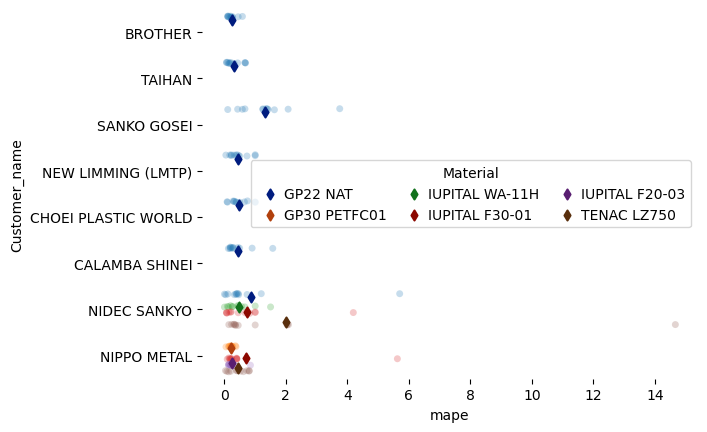

In [9]:
# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(
    data=error, x="mape", y="Customer_name", hue="Material",
    dodge=True, alpha=.25, zorder=1, legend=False
)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
sns.pointplot(
    data=error, x="mape", y="Customer_name", hue="Material",
    join=False, dodge=.8 - .8 / 3, palette="dark",
    markers="d", scale=.75, errorbar=None
)

# Improve the legend
sns.move_legend(
    ax, loc="right", ncol=3, frameon=True, columnspacing=1, handletextpad=0
)

In [49]:
nidec = perc_df[perc_df['Customer_name']=='NIDEC SANKYO']
nippo = perc_df[perc_df['Customer_name']=='NIPPO METAL']

In [43]:
nidec

,Year,Period,Material,Customer_name,period_inadv,perc_diff_F
720,2021,DEC,GP22 NAT,NIDEC SANKYO,9,NaN
721,2021,DEC,GP22 NAT,NIDEC SANKYO,8,NaN
722,2021,DEC,GP22 NAT,NIDEC SANKYO,7,NaN
723,2021,DEC,GP22 NAT,NIDEC SANKYO,6,NaN
724,2021,DEC,GP22 NAT,NIDEC SANKYO,5,6.6
...,...,...,...,...,...,...
1675,2022,NOV,TENAC LZ750,NIDEC SANKYO,4,1.0
1676,2022,NOV,TENAC LZ750,NIDEC SANKYO,3,1.0
1677,2022,NOV,TENAC LZ750,NIDEC SANKYO,2,1.0
1678,2022,NOV,TENAC LZ750,NIDEC SANKYO,1,1.0


<AxesSubplot: xlabel='period_inadv', ylabel='perc_diff_F'>

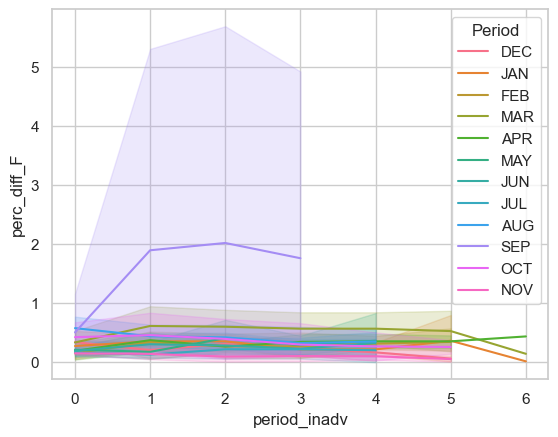

In [50]:
sns.set_theme(style="whitegrid")

sns.lineplot(x="period_inadv", y="perc_diff_F",
             hue="Period",
            #  style="Period",
             data=nippo)